In [8]:
import pandas as pd
from pathlib import Path
from lagom.utils import pickle_load
import matplotlib.pyplot as plt


def load_loggings(log_folder, ID, f):
    p = Path(log_folder)/str(ID)
    out = []
    for seed_folder in p.iterdir():
        if seed_folder.is_dir() and (seed_folder/f).exists():
            out.append(pickle_load(seed_folder/f))
    return out


def get_items(loggings, key):
    out = []
    for logging in loggings:
        items = [x[key][0] for x in logging]
        out.append(items)
    return out


def get_xy(loggings, x_key, y_key):
    x = get_items(loggings, x_key)
    y = get_items(loggings, y_key)
    return x, y

## VPG

In [129]:
log_folder = Path(f'vpg/logs/default/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())
configs

,ID,cuda,log.dir,log.freq,env.standardize_obs,env.standardize_reward,env.time_aware_obs,nn.sizes,agent.lr,agent.use_lr_scheduler,...,agent.entropy_coef,agent.value_coef,env.clip_action,agent.std0,agent.std_style,agent.std_range,agent.beta,train.timestep,train.timestep_per_iter,env.id
0,0,True,logs/default,10,True,True,False,"[64, 64]",0.001,False,...,0.01,0.5,True,0.5,exp,None,None,1000000,2000,HalfCheetah-v2
1,1,True,logs/default,10,True,True,False,"[64, 64]",0.001,False,...,0.01,0.5,True,0.5,exp,None,None,1000000,2000,Hopper-v2
2,2,True,logs/default,10,True,True,False,"[64, 64]",0.001,False,...,0.01,0.5,True,0.5,exp,None,None,1000000,2000,Ant-v2


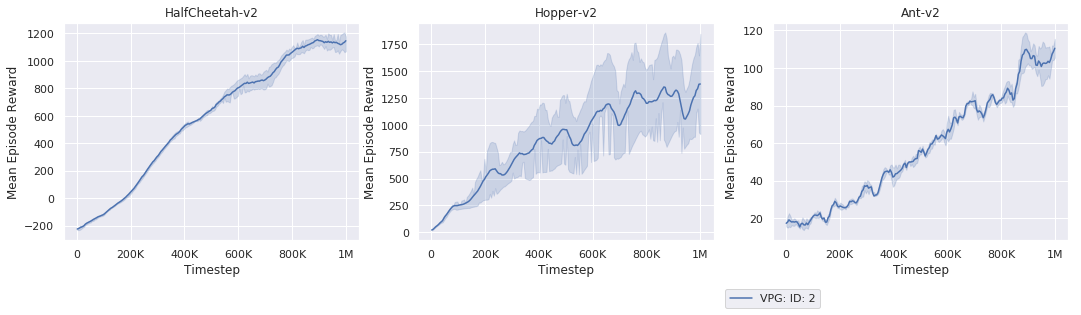

In [130]:
from lagom.vis import lineplot
from lagom.vis import auto_ax


fig, axes = plt.subplots(1, 3, figsize=[3*6, 4])
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}

x_key = 'accumulated_trained_timesteps'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'

hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'VPG: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})

ax = axes[1]
env_id = 'Hopper-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'VPG: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   
    
    
ax = axes[2]
env_id = 'Ant-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'VPG: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   

legend = ax.legend(loc='upper center', bbox_to_anchor=[0.0, -0.2], ncol=2)
fig.savefig(log_folder/'result.png', bbox_extra_artists=(ax.legend_,), bbox_inches='tight')

## PPO

In [105]:
log_folder = Path(f'ppo/logs/default/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())
configs

,ID,cuda,log.dir,log.freq,env.standardize_obs,env.standardize_reward,env.time_aware_obs,nn.recurrent,nn.sizes,agent.lr,...,env.clip_action,agent.std0,agent.std_style,agent.std_range,agent.beta,train.timestep,train.timestep_per_iter,train.batch_size,train.num_epochs,env.id
0,0,True,logs/default,10,True,True,False,False,"[64, 64]",0.0003,...,True,0.5,exp,None,None,1000000,2000,256,80,HalfCheetah-v2
1,1,True,logs/default,10,True,True,False,False,"[64, 64]",0.0003,...,True,0.5,exp,None,None,1000000,2000,256,80,Hopper-v2
2,2,True,logs/default,10,True,True,False,False,"[64, 64]",0.0003,...,True,0.5,exp,None,None,1000000,2000,256,80,Ant-v2


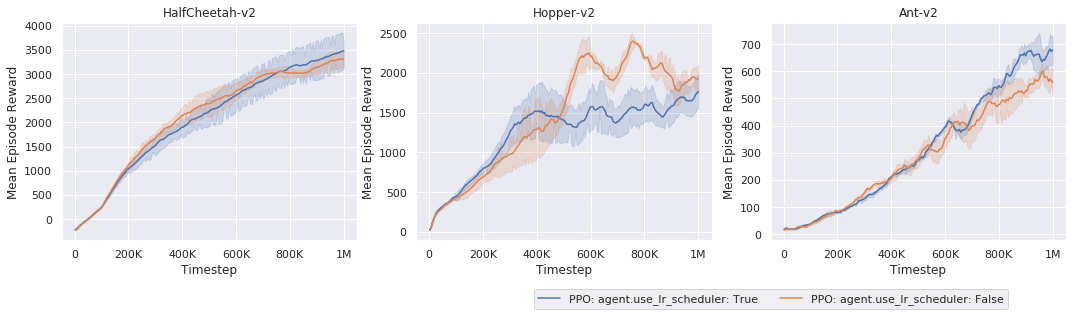

In [70]:
from lagom.vis import lineplot
from lagom.vis import auto_ax


fig, axes = plt.subplots(1, 3, figsize=[3*6, 4])
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}

x_key = 'accumulated_trained_timesteps'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'

hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})

ax = axes[1]
env_id = 'Hopper-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   
    
    
ax = axes[2]
env_id = 'Ant-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   

    
legend = ax.legend(loc='upper center', bbox_to_anchor=[0.0, -0.2], ncol=2)
fig.savefig(log_folder/'result.png', bbox_extra_artists=(ax.legend_,), bbox_inches='tight')

## DDPG

In [110]:
log_folder = Path(f'ddpg/logs/batch_size_128//')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())
configs

,ID,cuda,log.dir,log.freq,env.time_aware_obs,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.max_grad_norm,env.clip_action,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.freq,eval.num_episode,env.id
0,0,True,logs/batch_size_128,1,False,0.99,0.995,0.0001,False,0.001,False,None,True,1000000,10000,128,1000000,5000,10,HalfCheetah-v2


### TMP Plot

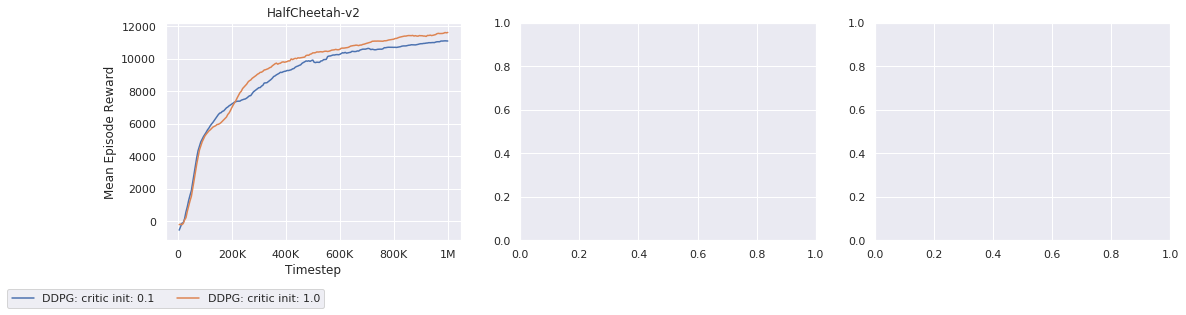

In [120]:
from lagom.vis import lineplot
from lagom.vis import auto_ax


fig, axes = plt.subplots(1, 3, figsize=[3*6, 4])
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}

x_key = 'accumulated_train_step'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'


log_folder = Path(f'ddpg/logs/critic_init/0.1/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())


hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'eval_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: critic init: 0.1')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})
    
    
    
log_folder = Path(f'ddpg/logs/critic_init/1.0/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())


hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'eval_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: critic init: 1.0')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})


    
legend = ax.legend(loc='upper center', bbox_to_anchor=[0.0, -0.2], ncol=2)
fig.savefig(log_folder/'result.png', bbox_extra_artists=(ax.legend_,), bbox_inches='tight')

ValueError: min() arg is an empty sequence

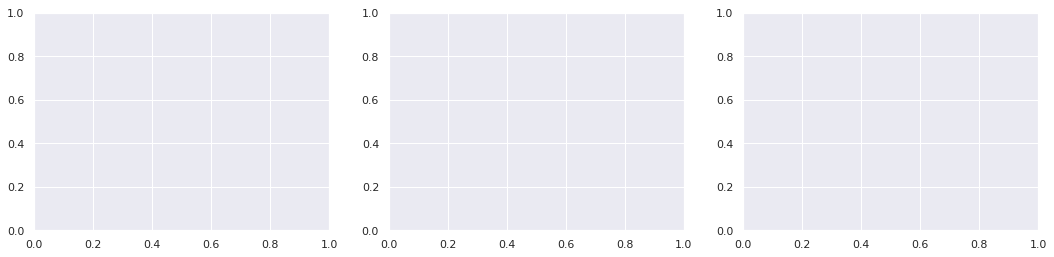

In [86]:
from lagom.vis import lineplot
from lagom.vis import auto_ax


fig, axes = plt.subplots(1, 3, figsize=[3*6, 4])
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}

x_key = 'accumulated_train_step'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'



log_folder = Path(f'ddpg/logs/batch_size_128/')

hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'eval_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: new')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})
    
    
    
log_folder = Path(f'ddpg/logs/default_/')

hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'eval_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: old')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})
    
    
    
log_folder = Path(f'ddpg/logs/default_our_/')

hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'eval_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: our')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})
    

    
"""
ax = axes[1]
env_id = 'Hopper-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   
    
    
ax = axes[2]
env_id = 'Ant-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   
"""
    
legend = ax.legend(loc='upper center', bbox_to_anchor=[0.0, -0.2], ncol=2)
fig.savefig(log_folder/'result.png', bbox_extra_artists=(ax.legend_,), bbox_inches='tight')